In [3]:
import os
import sys
import pandas as pd
import numpy as np
import regex as re
import mygene
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit, fminbound
from scipy import stats
from tableanalyser import *

In [4]:
mg = mygene.MyGeneInfo()

In [5]:
#mg.getgene("ENSG00000221782", 'name,symbol,refseq.rna,type_of_gene,exac.bp')

In [6]:
working_dir = "/Users/filippo/Developer/tesi"
os.chdir(working_dir)
dirs = os.listdir("data")

In [7]:
len(dirs)

4497

In [8]:
normalisation_str = "counts"

In [9]:
df = pd.read_csv(("%s/mainTable.csv"%working_dir))
df.columns.values[0] = 'gene'
#df = df.to_sparse(fill_value=0.)
df.head()

,gene,ab30d37c-c510-496f-a704-6687ea39b847.htseq.counts.gz,e89c96d6-a2ab-4bac-bbba-8c52d49a3edf.htseq.counts.gz,d2587070-cb7d-440d-ae49-52f5077248e6.htseq.counts.gz,e733093b-8a60-46d7-9ddd-ec8a82206126.htseq.counts.gz,f02be12f-2e34-4089-be5c-0f81ca6038c8.htseq.counts.gz,6b424e38-1004-4434-be48-ee01dad67982.htseq.counts.gz,6f8c77f2-67de-411d-a03d-5fef3216b71b.htseq.counts.gz,3490b791-16ec-41e8-9015-5f3d33c856c0.htseq.counts.gz,97675f21-ce94-4e7c-bc46-179cc2903bf3.htseq.counts.gz,...,87968a34-cdba-4335-92d9-0f5b34ed27c9.htseq.counts.gz,32f7779d-9065-4241-ad44-efe90148ac23.htseq.counts.gz,358f2893-02b2-4d36-9c76-b818c28b6027.htseq.counts.gz,11797830-6218-43c6-8c41-515583575668.htseq.counts.gz,8677d42c-aef1-444d-b9a2-0dbcced0e886.htseq.counts.gz,fbef38b2-454d-44e6-b27f-5a790c6f8c17.htseq.counts.gz,c327832d-9cf8-4734-a745-42879ebe6702.htseq_counts.txt.gz,90d19c5c-f80b-454b-b776-99d13f01617e.htseq.counts,6d9c73d6-215a-49f9-bc9f-af019f8db55c.htseq.counts.gz,9c9ee7b5-0227-43c2-be55-909751dbd61a.htseq.counts.gz
0,ENSG00000167578,475,494,1008,265,325,278,582,613,357,...,901,269,458,1395,621,384,403,697,369,392
1,ENSG00000078237,409,475,1082,660,804,535,1215,1226,751,...,485,651,154,812,674,73,395,598,1240,1090
2,ENSG00000146083,3211,4264,5319,3457,3864,1257,3702,3043,4536,...,2849,2141,1071,2456,4049,1466,1933,2840,2657,5324
3,ENSG00000158486,53,18,168,12,116,62,97,18,90,...,425,198,0,27,25,790,28,4,153,318
4,ENSG00000198242,11411,20733,15310,32889,11328,27760,15145,25741,18640,...,8388,14479,12937,24780,27905,15907,4641,24878,11621,39908


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19369 entries, 0 to 19368
Columns: 3635 entries, gene to 9c9ee7b5-0227-43c2-be55-909751dbd61a.htseq.counts.gz
dtypes: int64(3634), object(1)
memory usage: 537.2+ MB


In [11]:
ngenes = len(df['gene'])
nfiles = len(df.loc[0,:])-1
print("genes:%d\trealizations:%d"%(ngenes,nfiles))

genes:19369	realizations:3634


## Means sigmas

In [12]:
df_mv = pd.read_csv("meanVariances.csv", index_col = [0])
#type_of_gene='protein-coding'
#df_mv = df_mv.loc[df_mv['type_of_gene']==type_of_gene]
df_mv_occ=pd.read_csv("O.dat", header=None)
#df_mv.drop("type_of_gene", axis=1, inplace=True)
df_mv.insert(3, 'occurrence', df_mv_occ.values)
#df_mv.insert(2,'type_of_gene','protein-coding')
df_mv.head()

,mean,variance,type_of_gene,occurrence
ENSG00000167578,788.433,285765.0,,1.00000
ENSG00000078237,717.648,341307.0,,1.00000
ENSG00000146083,3921.110,8143170.0,,1.00000
ENSG00000158486,112.376,106166.0,,0.97716
ENSG00000198242,28493.700,631118000.0,,1.00000


In [13]:
#df_mv.to_csv("meanVariances.csv",index=True,header=True)

In [14]:
df_mv.fillna(value=0.,inplace=True)

In [15]:
means = df_mv['mean'].values
variances = df_mv['variance'].values
occurrences = np.array(df_mv['occurrence'].values*nfiles, dtype=int)
len(df_mv)

19369

### plot

#### **var** versus **mean**

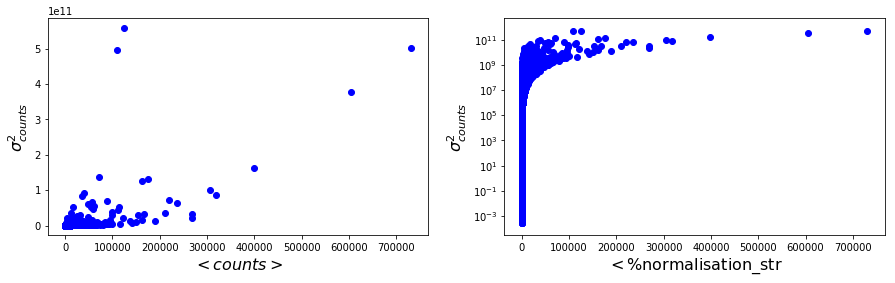

In [16]:
fig=plt.figure(figsize=(15,4))
plt.subplot(121)
plt.scatter(means, variances, c='b')
plt.xlabel("$<%s>$"%normalisation_str, fontsize=16)
plt.ylabel("$\sigma^2_{%s}$"%normalisation_str, fontsize=16)
plt.subplot(122)
plt.scatter(means, variances, c='b')
plt.xlabel("$<%s>$%normalisation_str", fontsize=16)
plt.ylabel("$\sigma^2_{%s}$"%normalisation_str, fontsize=16)
plt.yscale('log')
#plt.xlim(1e-2,200)
plt.ylim((variances[variances.nonzero()].min()/10,np.power(10,np.log10(variances.max())+1)))
plt.show()

In [17]:
fig.savefig("varmean.png")

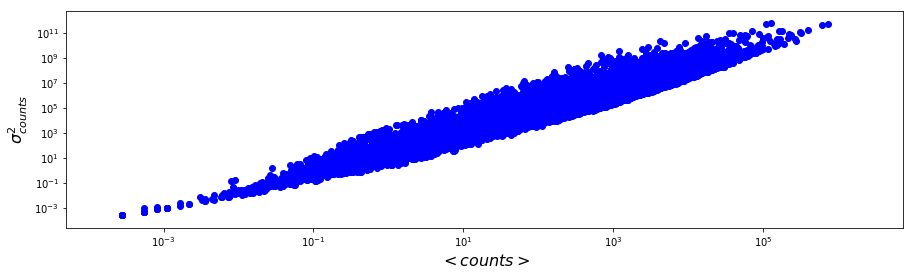

In [18]:
fig=plt.figure(figsize=(15,4))
plt.scatter(means, variances, c='b')
plt.xlabel("$<%s>$"%normalisation_str, fontsize=16)
plt.ylabel("$\sigma^2_{%s}$"%normalisation_str, fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.xlim(5e-5,np.power(10,np.log10(means.max())+1))
plt.ylim((variances[variances.nonzero()].min()/10,np.power(10,np.log10(variances.max())+1)))
plt.show()
fig.savefig("varmean_loglog.png")

### mean versus occurrence

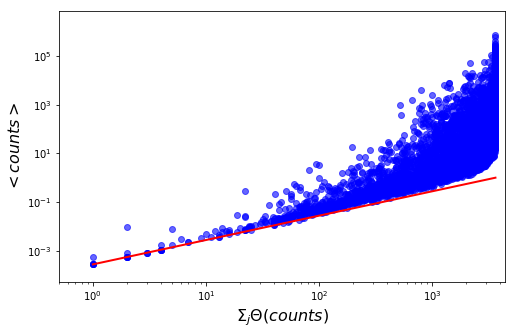

In [19]:
fig=plt.figure(figsize=(8,5))
plt.scatter(occurrences, means, c='b', alpha=0.6, label='data')
plt.plot(np.linspace(1,nfiles), np.linspace(1,nfiles)/(nfiles), lw=2, label='', c='r')
plt.ylabel("$<%s>$"%normalisation_str, fontsize=16)
#plt.xlabel("$\Sigma_j\Theta(FPKM-0.1)\Theta(1e5-FPKM)$", fontsize=16)
plt.xlabel("$\Sigma_j\Theta(%s)$"%normalisation_str, fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.ylim(5e-5,np.power(10,np.log10(means.max())+1))
plt.xlim(5e-1,nfiles+800)
plt.show()

In [20]:
fig.savefig("meanDiff_loglog.png")

### Distributions

In [21]:
len(means)

19369

In [22]:
len(variances)

19369

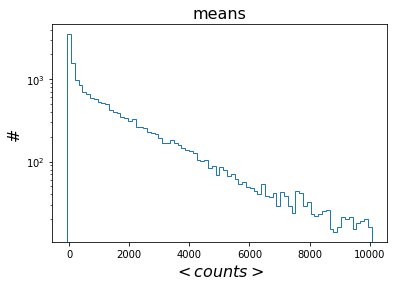

In [23]:
bins = 80
_range = (0-1e4*0.5/bins, 1e4+1e4*0.5/bins)
fig = plt.figure()
n, c, _ = plt.hist(means, density = False, range=_range, bins=bins, histtype='step')
plt.title("means", fontsize=16)
plt.xlabel("$<%s>$"%normalisation_str, fontsize=16)
plt.ylabel("#", fontsize=16)
plt.yscale('log')
plt.show()
fig.savefig("mean_distr.pdf")

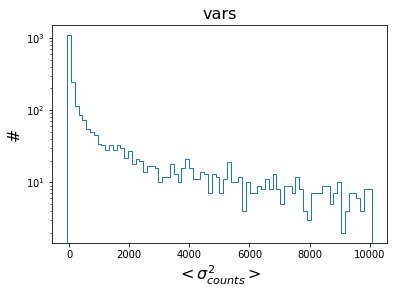

In [24]:
bins = 80
_range = (0-1e4*0.5/bins, 1e4+1e4*0.5/bins)
fig = plt.figure()
n, c, _ = plt.hist(variances, density = False, histtype='step', bins=bins, range=_range)
plt.title("vars", fontsize=16)
plt.xlabel("$<\sigma_{%s}^2>$"%normalisation_str, fontsize=16)
plt.ylabel("#", fontsize=16)
plt.yscale('log')
plt.show()
fig.savefig("var_distr.pdf")

# protein coding genes

In [ ]:
protein_coding = pd.read_csv("genes.txt", header=[0], index_col=[0])
pc = protein_coding.loc[protein_coding['type_of_gene']=='protein-coding'].index.values
pc

In [ ]:
df_mv = df_mv.loc[pc,:]

# expression plot

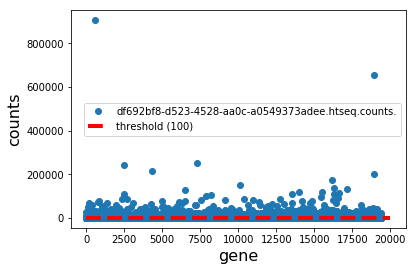

In [87]:
sample = 10
fig = plt.figure()
x = np.linspace(0, 20000)
key = df.keys()[sample]
plt.plot(df[key].to_dense(), 'o', label=key[:-2])
plt.plot(x, [100 for _ in x], 'r--', lw=4, label='threshold (100)')
plt.xlabel("gene", fontsize=16)
plt.ylabel("%s"%normalisation_str, fontsize=16)
plt.legend()
plt.show()

In [88]:
fig.savefig("singleFile.pdf")

# single gene

name: ENSG00000078237
mean:     717.65
var:  341307.03
occ:    3634.00


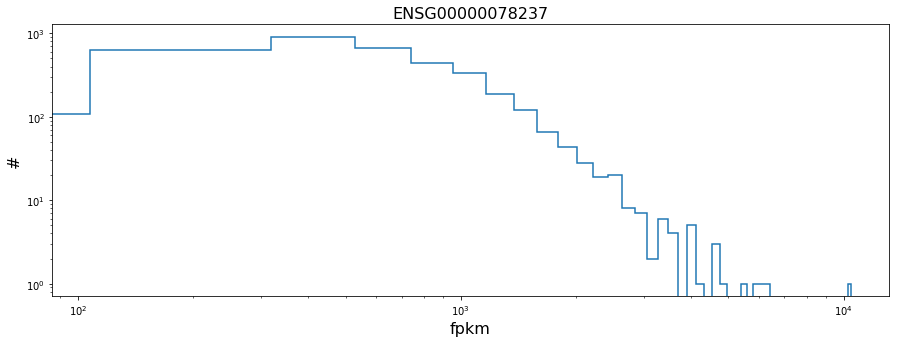

In [41]:
gene = geneinfo('ENSG00000078237', df, nfiles)
genedistr(gene, 50);
#geneplot(gene);
#genecoord(gene, means, variances);

# subset analysis

### query genes

#### by mean and variance

In [ ]:
search_mean_max = 200
search_mean_min = 50
search_var_max = 1e12
search_var_min = 1e6
pc = True
if (pc):
    query_result = df_mv.loc[(df_mv['type_of_gene']=='protein-coding')&((df_mv['mean']>(search_mean_min)) & (df_mv['mean']<(search_mean_max))) & ((df_mv['variance']>(search_var_min)) & (df_mv['variance']<(search_var_max)))].sort_values(by='mean')
else:
    query_result = df_mv.loc[((df_mv['mean']>(search_mean_min)) & (df_mv['mean']<(search_mean_max))) & ((df_mv['variance']>(search_var_min)) & (df_mv['variance']<(search_var_max)))].sort_values(by='mean')
query_result

#### by occurrence

In [50]:
search_mean_min = 1e5
search_occ_min = 0.995
query_result = df_mv.loc[(df_mv['mean']>(search_mean_min)) & (df_mv['occurrence']>(search_occ_min))].sort_values(by='mean')

In [51]:
genesnames = []
for g in query_result.index.values[:5]:
    gene = geneinfo(g, df, nfiles, metric=normalisation_str)
    genesnames.append(gene)

name: ENSG00000164692
mean:  111949.25
var: 44194872214.82
occ:    3621.00
name: ENSG00000100316
mean:  116622.32
var: 4773215369.40
occ:    3634.00
name: ENSG00000019582
mean:  121985.29
var: 20122773352.32
occ:    3634.00
name: ENSG00000042832
mean:  125489.31
var: 558640126513.49
occ:    3628.00
name: ENSG00000166710
mean:  138220.15
var: 12113307852.42
occ:    3634.00


### plot coordinates

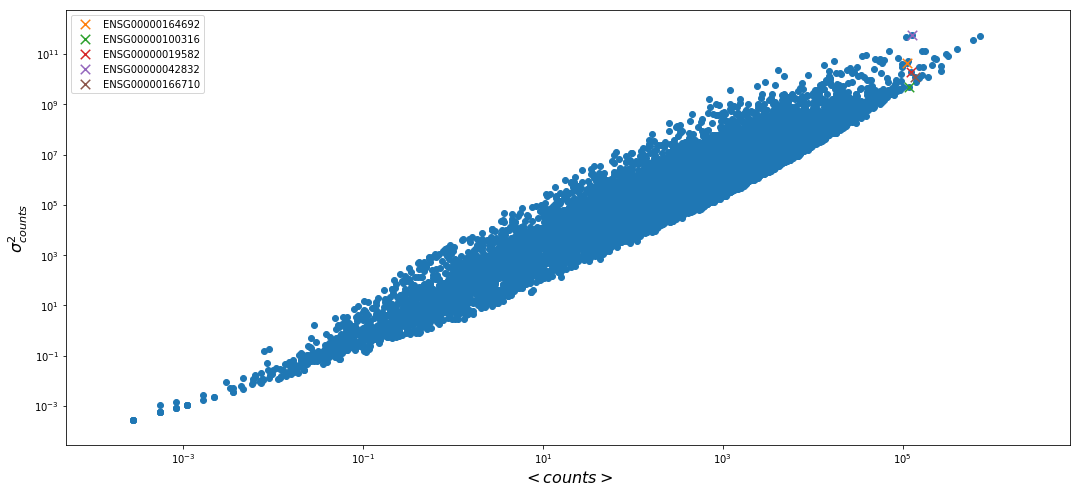

In [52]:
fig = plt.figure(figsize=(18,8))
plt.scatter(means, variances)
for g in genesnames:
    plt.scatter([g['avg']],[g['var']], marker='x', s=90, label=g['name'])
plt.xlabel("$<%s>$"%normalisation_str, fontsize=16)
plt.ylabel("$\sigma^2_{%s}$"%normalisation_str, fontsize=16)
plt.yscale('log')
plt.xlim(5e-5,np.power(10,np.log10(means.max())+1))
plt.ylim((variances[variances.nonzero()].min()/10,np.power(10,np.log10(variances.max())+1)))
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()
fig.savefig("plot/genes/subset.png")

### plot all

ENSG00000164692
mean: 111949.252339
var: 44194872214.823227
ENSG00000100316
mean: 116622.315080
var: 4773215369.400724
ENSG00000019582
mean: 121985.293065
var: 20122773352.323853
ENSG00000042832
mean: 125489.305724
var: 558640126513.489624
ENSG00000166710
mean: 138220.150248
var: 12113307852.421564


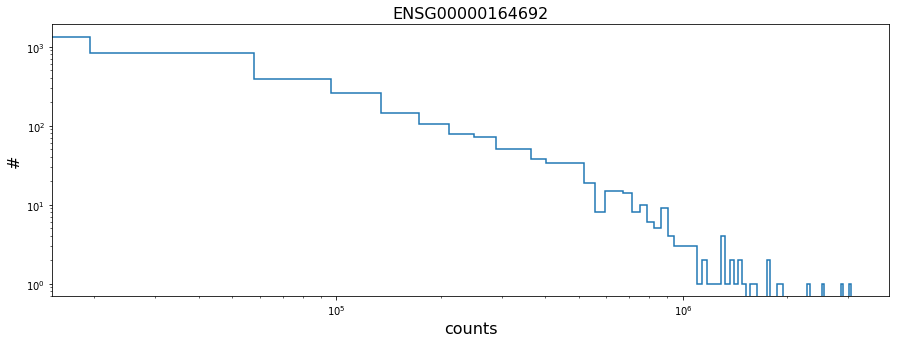

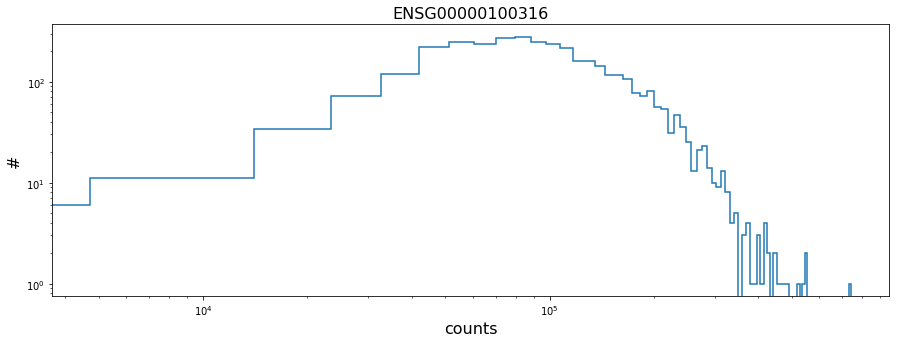

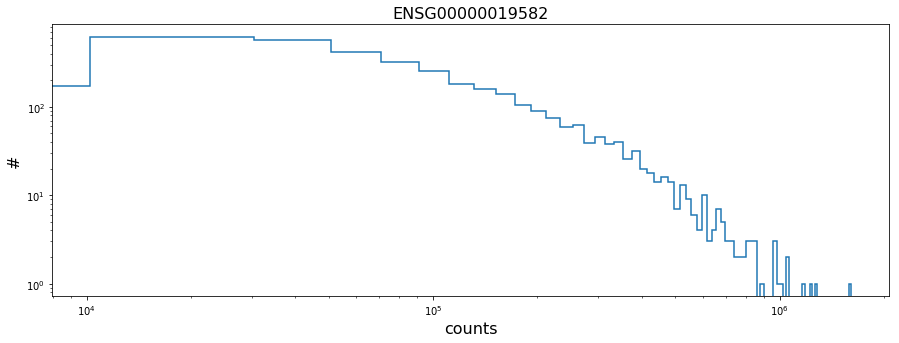

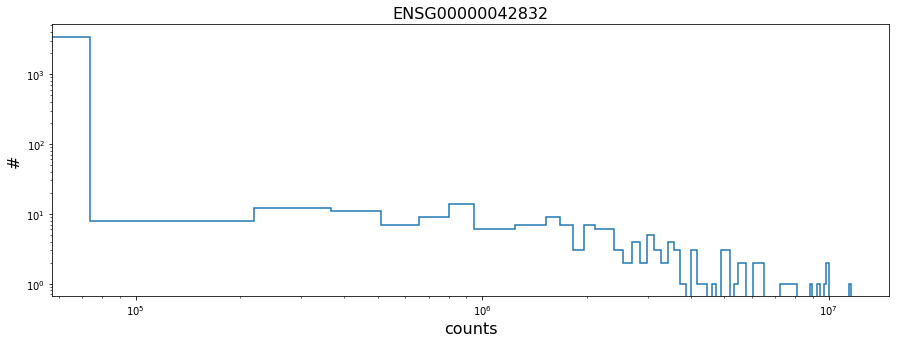

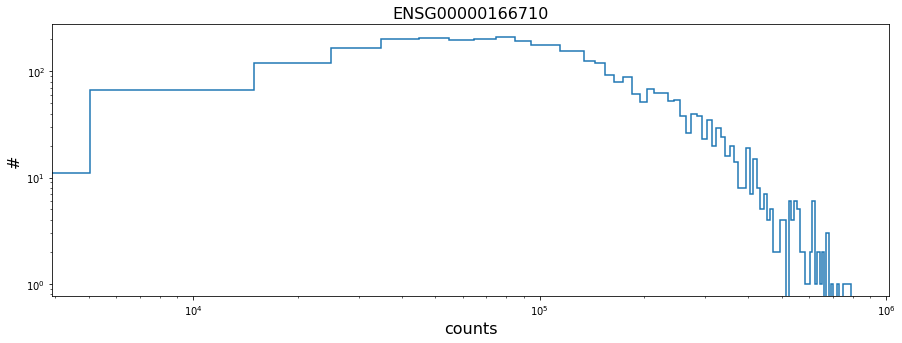

In [53]:
for gene in genesnames:
    print(gene['name'])
    print("mean: %f"%gene['avg'])
    print("var: %f"%gene['var'])
    genedistr(gene, 80, metric=normalisation_str);
    #geneplot(gene);
    #genecoord(gene);

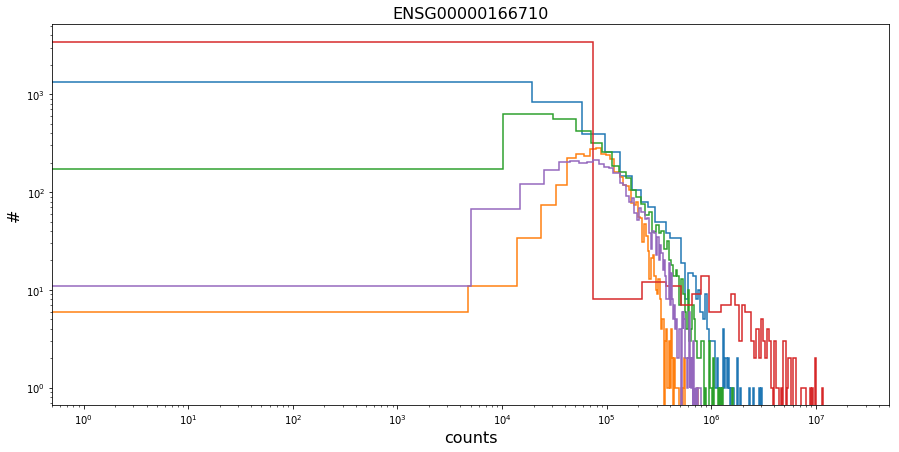

In [57]:
fig = plt.figure(figsize=(15,7))
ax = plt.subplot()
ax.set_title("highmean_highO")
for gene in genesnames:
    genedistr(gene, 80, metric=normalisation_str,ax=ax);
ax.set_xlim(0.5,5e7)
plt.show()
fig.savefig("highmean_highO.pdf")

In [30]:
def powgaus(x, a, b, c, d, e):
    return np.exp(a*np.power(x,-b)) - 1 + e*(np.exp(np.exp(-(x-c)*(x-c)/d)) - 1)

In [31]:
fitfunc = powgaus

[3.19290544e+01 3.00000000e-01 3.00000000e+03 5.00000000e+05
 1.00005098e-02]


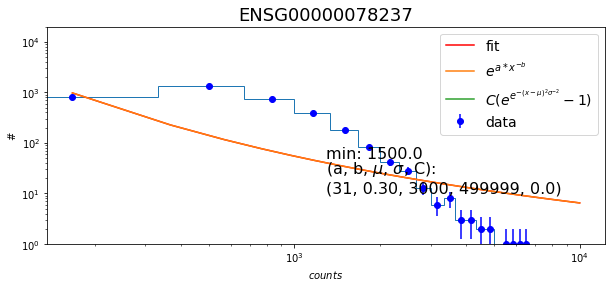

In [36]:
xscale = 'log'
yscale='log'
bins = 30
fig = plt.figure(figsize=(10,4))
ax = fig.subplots()
counts, bin_edges, _ = ax.hist(gene['data'], histtype='step', bins=bins, range=(0,1e4))
bin_centres = (bin_edges[1:]+bin_edges[:-1])/2.
ax.errorbar(bin_centres, counts, np.sqrt(counts), None, 'bo', label='data')
bounds = ([2, 0.3, 3000, 1000, 0.01],[1000, 0.7, 5000, 500000, 3])
popt, pcov = curve_fit(fitfunc, bin_centres, counts, bounds=bounds)
print(popt)
x = np.linspace(bin_centres[0],1e4)
ax.set_title(gene['name'], fontsize=18)
ax.set_xlabel("$%s$"%normalisation_str)
ax.set_ylabel("#")
ax.set_yscale(yscale)
ax.set_xscale(xscale)
minimum = fminbound(fitfunc, 100, 1500, args=(popt[0],popt[1],popt[2],popt[3],popt[4]))
plt.plot(x, fitfunc(x, *popt), 'r', label='fit')
plt.plot(x, np.exp(popt[0]*np.power(x,-popt[1])) - 1, label='$e^{a*x^{-b}}$')
plt.plot(x, popt[4]*np.exp(np.exp(-(x-popt[2])*(x-popt[2])/popt[3])) - popt[4], label="$C(e^{e^{- (x-\mu)^2\sigma^{-2}}}-1)$")
plt.text(0.5, 0.45, 'min: %6.1f'%minimum, horizontalalignment='left',verticalalignment='top', fontsize=16, transform=ax.transAxes)
plt.text(0.5, 0.4, '(a, b, $\mu$, $\sigma$, C):\n(%d, %4.2f, %d, %d, %3.1f)'%(popt[0],popt[1],popt[2],popt[3],popt[4]), horizontalalignment='left',verticalalignment='top', fontsize=16, transform=ax.transAxes)
plt.ylim(1,2e4)
plt.legend(fontsize=14)
plt.show()

# null

In [ ]:
#df_null = pd.read_csv(("%s/nullTable.csv"%working_dir), header=None, index_col=None)

In [ ]:
#df_null.head()

In [ ]:
#means_null = [np.average(df_null.loc[i,df_null.keys()[1:]].values) for i,g in enumerate(df_null.loc[:,df_null.keys()[0]].values)]
#variances_null = [np.var(df_null.loc[i,df_null.keys()[1:]].values) for i,g in enumerate(df_null.loc[:,df_null.keys()[0]].values)]

## meanVariances

In [ ]:
df_mv_null = pd.read_csv("meanVariances_null.csv", usecols=[1,2])
df_mv_null.head()

In [ ]:
df_occ_null = pd.read_csv("O_null.dat", header=None)
df_mv_null.insert(2,'occurrence', np.array(df_occ_null.values,dtype=float))
df_mv_null.head()

In [ ]:
means_null = df_mv_null['mean'].values
variances_null = df_mv_null['variance'].values
occurrences_null = np.array(df_mv_null['occurrence'].values, dtype=float)*nfiles
len(df_mv_null)

In [78]:
x_lin = np.logspace(np.log10(x[x.nonzero()].min()),np.log10(x[x.nonzero()].max()), dtype=float,num=50)
x = means
y = variances

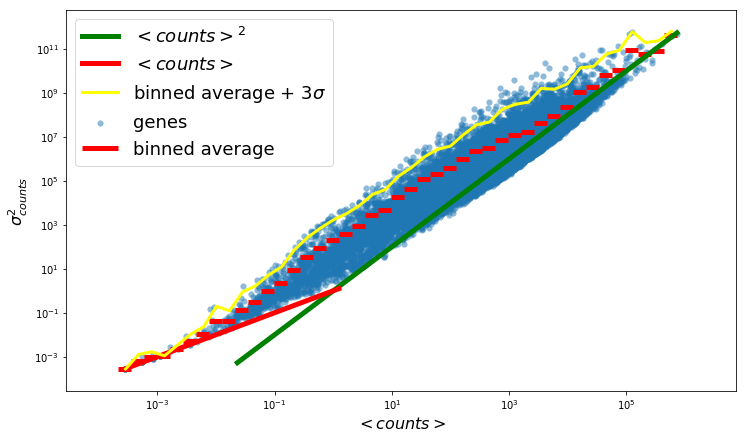

In [84]:
fig=plt.figure(figsize=(12,7))

plt.scatter(x, y, label = 'genes', marker='o', alpha=0.5, linewidths=0.1)

log_bins_for_x = np.logspace(-5, np.log10(np.max(x)), num=50)
bin_means, bin_edges, binnumber = stats.binned_statistic(x, y, statistic='mean', bins=log_bins_for_x)
bin_centres = (bin_edges[:-1]+bin_edges[1:])/2
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=5, label='binned average')

plt.plot(x_lin[-40:],np.power(x_lin[-40:],2), 'g-', lw=5, label='$<%s>^2$'%normalisation_str)
plt.plot(x_lin[:20],x_lin[:20], 'r-', lw=5, label='$<%s>$'%normalisation_str)



#popt, pcov = curve_fit(lambda x,a,b : a*np.power(x,b), bin_centres, bin_means, bounds=([1,1],[35,5]))
#plt.plot(bin_centres, popt[0]*np.power(bin_centres, popt[1]), color='y', lw=3, label='fit')
#print(popt[0],popt[1])

bin_sigmas,  bin_sigmas_edges, binsigmanumber = stats.binned_statistic(x, y, statistic=np.std, bins=log_bins_for_x)
plt.plot((bin_edges[:-1] + bin_edges[1:])/2, bin_means+bin_sigmas*3, lw=3, color='yellow', label='binned average + $3\sigma$')


#plt.scatter(means_null, variances_null, label='sampling')

plt.xlabel("$<%s>$"%normalisation_str, fontsize=16)
plt.ylabel("$\sigma^2_{%s}$"%normalisation_str, fontsize=16)
plt.legend(fontsize=18)
plt.xscale('log')
plt.yscale('log')
plt.xlim(x[x.nonzero()].min()/10,np.power(10,np.log10(x.max())+1))
plt.ylim((y[y.nonzero()].min()/10,np.power(10,np.log10(y.max())+1)))
plt.show()

In [85]:
fig.savefig("varmean_3sigma.png")

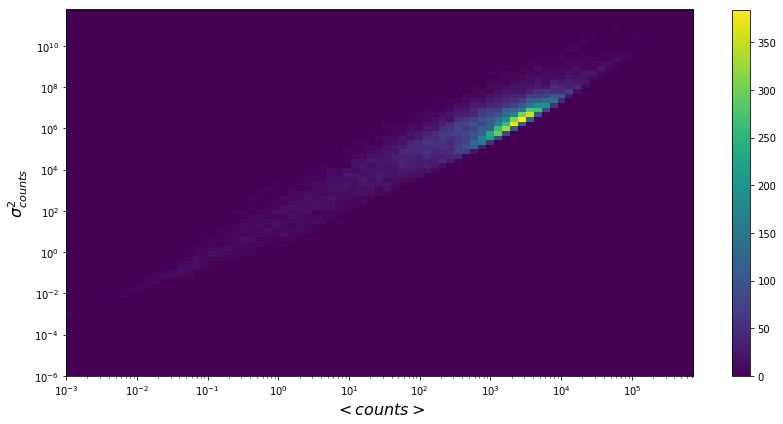

In [86]:
x = means
y = variances

# INIT FIGURE #################################################################

fig = plt.figure(figsize=(12, 6))
ax = fig.subplots()


# AX #########################################################################

xmin = np.log10(1e-3)
xmax = np.log10(x.max())
ymin = np.log10(1e-6)
ymax = np.log10(y.max())

nbins=80

xbins = np.logspace(xmin, xmax, nbins) # <- make a range from 10**xmin to 10**xmax
ybins = np.logspace(ymin, ymax, nbins) # <- make a range from 10**ymin to 10**ymax
counts, _, _, _ = ax.hist2d(x, y, bins=(xbins, ybins));

pcm = ax.pcolormesh(xbins, ybins, counts.T)
plt.colorbar(pcm)
#fig.colorbar(pcm, ax=ax)  # this works too


ax.set_xscale("log")               # <- Activate log scale on X axis
ax.set_yscale("log")               # <- Activate log scale on Y axis

ax.set_xlim(xmin=xbins[0])
ax.set_xlim(xmax=xbins[-1])
ax.set_ylim(ymin=ybins[0])
ax.set_ylim(ymax=ybins[-1])

ax.set_title("")
ax.set_xlabel("$<%s>$"%normalisation_str, fontsize=16)
ax.set_ylabel("$\sigma^2_{%s}$"%normalisation_str, fontsize=16)

# SHOW AND SAVE FILE ##########################################################

plt.tight_layout()
plt.show()
fig.savefig("varmean_density.png")

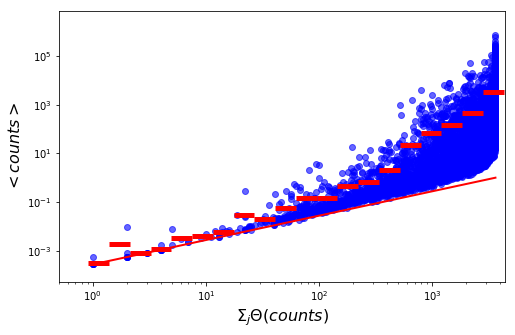

In [59]:
fig=plt.figure(figsize=(8,5))
plt.scatter(occurrences, means, c='b', alpha=0.6, label='data')

log_bins_for_x = np.logspace(-5, np.log10(np.max(x)), num=50)
bin_means, bin_edges, binnumber = stats.binned_statistic(occurrences, means, statistic='mean', bins=log_bins_for_x)
bin_centres = (bin_edges[:-1]+bin_edges[1:])/2
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=5, label='binned average')

plt.plot(np.linspace(1,nfiles), np.linspace(1,nfiles)/(nfiles), lw=2, label='', c='r')
plt.ylabel("$<%s>$"%normalisation_str, fontsize=16)
#plt.xlabel("$\Sigma_j\Theta(FPKM-0.1)\Theta(1e5-FPKM)$", fontsize=16)
plt.xlabel("$\Sigma_j\Theta(%s)$"%normalisation_str, fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.ylim(5e-5,np.power(10,np.log10(means.max())+1))
plt.xlim(5e-1,nfiles+800)
plt.show()
fig.savefig("meanDiff_binned.png")

# overexpressed

In [ ]:
bin_means, bin_edges, binnumber = stats.binned_statistic(x, y, statistic='mean', bins=log_bins_for_x)
bin_sigmas,  bin_sigmas_edges, binsigmanumber = stats.binned_statistic(x, y, statistic=np.std, bins=log_bins_for_x)

def get_mean_sigma(mean, sigma):
    bin_i = 0
    for i,_ in enumerate(bin_edges[:-1]):
        if mean<bin_edges[i+1] and mean > bin_edges[i]:
            bin_i = i
            break
    #print(bin_edges[bin_i],bin_edges[bin_i+1])
    return(mean, sigma, bin_means[bin_i], bin_sigmas[bin_i], sigma>(bin_means[bin_i]+3*bin_sigmas[bin_i]))

In [ ]:
over = []
for g in df_mv.index:
    subdf = df_mv.loc[g,:]
    mean = subdf['mean']
    sigma = subdf['variance']
    r = get_mean_sigma(mean,sigma)
    if r[4]:
        over.append(g)

In [ ]:
len(over)

In [ ]:
for g in over:
    print(g)

## over mean

In [ ]:
from matplotlib.patches import Rectangle

In [ ]:
o_min = 3e1
o_max = nfiles
m_min = 5e4
m_max = 1e6

In [ ]:
fig=plt.figure(figsize=(8,5))
plt.scatter(occurrences, means, c='b', alpha=0.6, label='data')
plt.plot(np.linspace(1,nfiles), np.linspace(1,nfiles)/(nfiles*10), lw=2, label='', c='r')

width = o_max - o_min
height = m_max-m_min
plt.gca().add_patch(Rectangle((o_min,m_min), width=width, height=height, fill=False))

plt.ylabel("$<%s>$"%normalisation_str, fontsize=16)
#plt.xlabel("$\Sigma_j\Theta(FPKM-0.1)\Theta(1e5-FPKM)$", fontsize=16)
plt.xlabel("$\Sigma_j\Theta(%s)$"%normalisation_str, fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.ylim(5e-5,np.power(10,np.log10(means.max())+1))
plt.xlim(5e-1,nfiles+800)
plt.show()
plt.savefig("highmean.png")

In [ ]:
up = []
for g in df_mv.index:
    subdf = df_mv.loc[g,:]
    mean = subdf['mean']
    occ = subdf['occurrence']
    if mean>m_min and mean < m_max and occ*nfiles > o_min and occ*nfiles< o_max:
        up.append(g)

In [ ]:
len(up)

In [ ]:
for g in up:
    print(g)

## with null model

In [ ]:
fig=plt.figure(figsize=(9,5))
plt.scatter(occurrences, means, c='b', label='data', alpha=0.6)
plt.scatter(occurrences_null, means_null, c='r', label='sampling')
#plt.plot(np.logspace(-1,4),1e-1/5000.*np.logspace(-1,4))
plt.ylabel("$<%s>$"%normalisation_str, fontsize=16)
#plt.xlabel("$\Sigma_j\Theta(FPKM-0.1)\Theta(1e5-FPKM)$", fontsize=16)
plt.xlabel("$\Sigma_j\Theta(%s)$"%normalisation_str, fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.ylim(5e-5,np.power(10,np.log10(means.max())+1))
plt.xlim(5e-1,nfiles+800)
plt.legend(fontsize=16)
plt.show()

In [ ]:
fig.savefig("meanDiff_null.png")

## set by occurrence

In [ ]:
with open("o1.txt",'a') as f:
    for g in df_mv[df_mv['occurrence']>4990].index:
        f.write("%s\n"%g)

## data size Heaps check

In [11]:
col = df.loc[:,df.keys()[1]].values
np.sum(col)

33955910

In [12]:
len(col[col.nonzero()])

17225

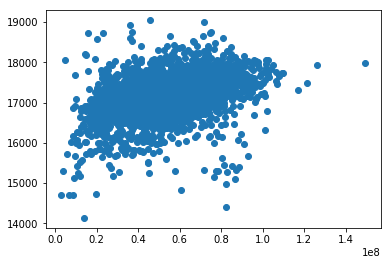

In [18]:
x = []
y = []
for i in range(1, nfiles):
    col = df.loc[:,df.keys()[i]].values
    x.append(np.sum(col))
    y.append(len(col.nonzero()[0]))
plt.scatter(x,y)

In [62]:
i=794
x=[]
y=[]
col = df.loc[:,df.keys()[i]].values
x.append(np.sum(col))
y.append(len(col.nonzero()[0]))

In [63]:
x

[42013037]

In [64]:
y

[17721]

In [52]:
col[8142:8150]

array([   0,  729,    0,   83,    0, 2944,    1, 2949])